In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np

In [3]:
#Patch Embedding
class PatchEmbedding(nn.Module):
	def __init__(self, img_size, patch_size, in_channel, embed_size):
		super().__init__()
		self.img_size = img_size
		self.patch_size = patch_size
		self.in_channel = in_channel
		self.embed_size = embed_size

		assert img_size % patch_size == 0
		self.num_patches = (img_size // patch_size)**2
		self.conv1 = nn.Conv2d(in_channel, self.embed_size, self.patch_size, self.patch_size)
		self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_size))
		self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches+1, embed_size))
		
		nn.init.trunc_normal_(self.pos_embedding, std=0.02)
		nn.init.trunc_normal_(self.cls_token, std=0.02)
		# nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')

	def forward(self, x): #need to convert [B, 3, 32, 32] to [B, num_patches + 1, embed_size]
		x = self.conv1(x) # [B, embed_size, 8, 8]
		x = x.flatten(2) #[B, embed_size, 64]
		x = x.transpose(1, 2) # [B, 64, embed_size]

		#add clk token
		B = x.shape[0]
		cls_tokens = self.cls_token.expand(B, -1, -1)
		x = torch.cat((cls_tokens, x), dim=1) # [B, 65, embed_size]
		x = x + self.pos_embedding
		return x
		

In [4]:
model = PatchEmbedding(img_size=32, patch_size=4, in_channel=3, embed_size=256)
demo = torch.randn(8, 3, 32, 32)
out = model(demo)
print(out.shape)

torch.Size([8, 65, 256])


In [ ]:
class MultiHeadAttention(nn.Module):
	def __init__(self, num_heads, embed_size, dropout=0.1):
		super().__init__()
		self.num_heads = num_heads
		self.embed_size = embed_size
		assert embed_size % num_heads == 0

		self.head_dim = embed_size // num_heads
		self.qkv_project = nn.Linear(embed_size, 3 * embed_size)
		self.dropout = nn.Dropout(dropout)
		self.fc = nn.Linear(embed_size, embed_size)
		
		
	def forward(self, x):
		B, N, D = x.shape
		d_k = self.head_dim
		qkv = self.qkv_project(x) #[B, N, D*3]
		qkv = qkv.reshape(B, N, 3, self.num_heads, d_k) # [B, N, 3, H, d_k]
		qkv = qkv.permute(2, 0, 3, 1, 4) # [3, B, H, N, d_k]
		Q, K, V = qkv[0], qkv[1], qkv[2] #[B, H, N, d_k]

		#Compute Attention Score
		# Attention(Q, K, V) = Softmax(QK^T / sqrt(query_size)) * V
		scores = (Q @ K.transpose(2, 3)) / (d_k ** 0.5) #[B, H, N, N]
		scores = F.softmax(scores, dim = -1)
		scores = self.dropout(scores)
		context = scores @ V # [B, H, N, d_k] ? 
		context = context.transpose(1, 2) # [B, N, H, d_k]
		context = context.reshape(B, N, D)

		out = self.fc(context)
		return out


In [6]:
class TransformerEncoder(nn.Module):
	def __init__(self, embed_size, dropout=0.1):
		super().__init__()
		self.embed_size = embed_size
		self.dropout = nn.Dropout(dropout)
		self.norm1 = nn.LayerNorm(embed_size)
		self.attn = MultiHeadAttention(num_heads=8, embed_size=embed_size, dropout=dropout)
		self.norm2 = nn.LayerNorm(embed_size)
		self.MLP = nn.Sequential(
			nn.Linear(embed_size, embed_size*4), # SECOND ONE CAN BE CHANGED
			nn.ReLU(),
			nn.Dropout(dropout),
			nn.Linear(embed_size*4, embed_size),
			nn.Dropout(dropout)
		)

	def forward(self, x):
		x = x + self.attn(self.norm1(x))
		x = x + self.MLP(self.norm2(x))
		return x

In [7]:
class ViT(nn.Module):
	def __init__(self, num_class, img_size, patch_size, in_channel, embed_size, num_heads, depth, dropout=0.1):
		super().__init__()
		self.img_size = img_size
		self.patch_size = patch_size
		self.in_channel = in_channel
		self.embed_size = embed_size
		self.num_heads = num_heads
		self.dropout = nn.Dropout(dropout)
		
		self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channel, embed_size)
		self.layers = nn.ModuleList([
			TransformerEncoder(embed_size, dropout) for _ in range(depth)
		])
		self.mlp_head = nn.Sequential(
			nn.Linear(embed_size, embed_size*4), # ?
			nn.ReLU(),
			nn.Dropout(dropout),
			nn.Linear(embed_size*4, num_class)
		)

	def forward(self, x):
		x = self.patch_embedding(x)
		for layer in self.layers:
			x = layer(x)
		cls_token_out = x[:, 0] #[B, embed_size]
		logits = self.mlp_head(cls_token_out)
		return logits
		

C:\Users\raymo\AppData\Local\Temp\ipykernel_33884\276447040.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'../experiments/run3/{i}_checkpoint

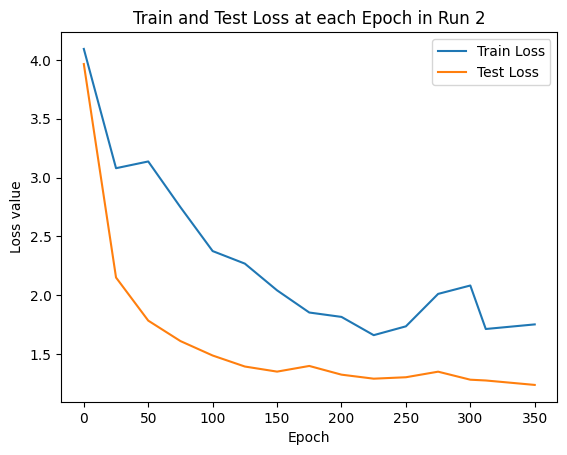

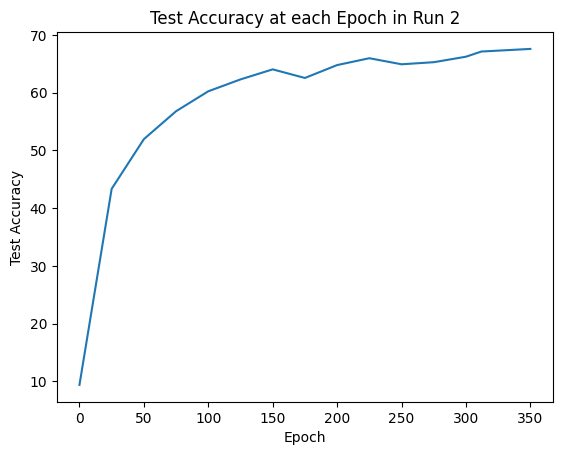

In [ ]:
import matplotlib.pyplot as plt

train_loss = []
# Run 2 Loss/Accuracy
# epoch = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]
# test_loss = [3.8507, 2.0292, 1.6843, 1.4992, 1.4177, 1.36, 1.3856, 1.3404, 1.3247, 1.3353]
# test_accuracy = [10.33, 45.44, 53.90, 59.01, 61.69, 63.44, 63.43, 64.14, 65.65, 65.33]

# Run 3 Loss/Accuracy
epoch = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 312, 350]
test_loss = [3.9655, 2.1492, 1.7825, 1.6085, 1.4856, 1.3919, 1.3486, 1.3968, 1.3227, 1.2885, 1.3007, 1.3481, 1.2798, 1.2732, 1.2354]
test_accuracy = [9.37, 43.33, 51.94, 56.78, 60.23, 62.29, 64.03, 62.54, 64.77, 65.96, 64.91, 65.27, 66.22, 67.12, 67.57]

for i in range(0, 375, 25):
	checkpoint = torch.load(f'../experiments/run3/{i}_checkpoint')
	train_loss.append(checkpoint['loss'].item())


plt.plot(epoch, train_loss, label="Train Loss")
plt.plot(epoch, test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title("Train and Test Loss at each Epoch in Run 2")
plt.legend()
plt.show()

plt.plot(epoch, test_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy at each Epoch in Run 2")
# plt.legend()
plt.show()